# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import itertools
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
from utils import plot_embedings2d, plotly_embedings2d

# Read pairs

In [2]:
edges_df = pd.read_csv("data/mammal_connections.csv", index_col='id')
edges_df = edges_df.drop_duplicates()

In [3]:
df = pd.read_csv("data/mammal_connections.csv", index_col='id')
print(df.shape)
df[:3]

(6575, 2)


from              to
id                                
0      mammal.n.01  placental.n.01
1   placental.n.01  carnivore.n.01
2   carnivore.n.01     feline.n.01

In [5]:
left2index = {w: i for i, w in enumerate(df['from'].unique())}
right2index = {w: i for i, w in enumerate(df['to'].unique())}

len(left2index), len(right2index), len(set(df['to'].unique()))

(293, 1181, 1181)

In [7]:
corpus = set(df['from'].unique()) | set(df['to'].unique())

word2index = {w: i for i, w in enumerate(corpus)}
index2word = {i: w for i, w in enumerate(corpus)}

len(word2index)

1182

In [9]:
# pickle.dump(index2word, open("models/index2word_connections.pkl", 'wb'))

In [10]:
index2word = pickle.load(open("models/index2word_connections.pkl", 'rb'))
word2index = {v: k for k, v in index2word.items()}
len(word2index)

1182

In [11]:
num_words = len(corpus)
num_words

1182

In [12]:
df['from'] = df['from'].map(word2index)
df['to'] = df['to'].map(word2index)
df[:3]

from    to
id            
0   1142    62
1     62   745
2    745  1045

In [13]:
x_train, y_train = df.values[:, 0], df.values[:, 1]
x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)
x_train.shape, y_train.shape

((6575, 1), (6575, 1))

## Data generator for sampling

In [14]:
def data_generator(x_data, y_data, num_samples=10, batch_size = 32):
    indices = np.array(list(range(x_data.shape[0])))
    while True:
        random_batch = np.random.choice(indices, batch_size, replace=False)
        x_batch = x_data[random_batch]
        y_batch = y_data[random_batch]
        
        x_samples = []
        for b in range(batch_size):
            random_batch = np.random.choice(indices, num_samples, replace=False)            
            x_sample = x_data[random_batch][:, 0]   
            if (np.where(x_batch[b, 0] == x_sample)[0].shape[0] == 0):
                x_sample[0] = x_batch[b, 0]
                
            x_samples.append(x_sample)        
        x_samples = np.array(x_samples)        
        yield [x_batch, y_batch, x_samples], y_batch
        
        
# define training generator
num_samples = 20
train_gen = data_generator(x_train, y_train, num_samples=num_samples)
[x_batch, y_batch, x_samples], y_labels = next(train_gen)
x_batch.shape, x_samples.shape, y_batch.shape

((32, 1), (32, 20), (32, 1))

# Keras model

## Imports

In [15]:
import keras
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
import keras.backend as K
import tensorflow as tf

def custom_loss(y_true, y_pred):
    return K.mean(y_pred)

def plot_embedings(word_embd_layer, mode='plt', center=True):
    
    w_embd = word_embd_layer.get_weights()[0]
    words = list(map(lambda x: index2word[x], range(num_words)))
    embeddings_df = pd.DataFrame( w_embd, columns=['x1', 'x2'], index=words)
    
    if mode == 'plt':
        plot_embedings2d(embeddings_df, edges_df, center)  
    elif mode == 'plotly':
        plotly_embedings2d(embeddings_df, edges_df, center)

Using TensorFlow backend.


## Check inner products

In [16]:
def get_inner_model(latent_dim = 2):
    left_input = Input(shape=(1,))
    word_embd = Embedding(num_words, output_dim=latent_dim, name='embeddings')
    u_word = word_embd(left_input)

    def u_w_distance(x):
        u = x
        w = word_embd.weights[0]    
        return K.dot(u, K.transpose(w))

    x = Lambda(u_w_distance)(u_word)
    x = Reshape(target_shape=[-1])(x)
    x = Activation('softmax')(x)

    model = Model(inputs=left_input, outputs=x)
    return model

model = get_inner_model(latent_dim = 2)

In [17]:
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=20)

model.compile(optimizer=Adam(0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=30)

model.compile(optimizer=Adam(0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10)

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/20
6575/6575 [==============================] - 1s - loss: 7.0366 - acc: 0.1098     
Epoch 2/20
6575/6575 [==============================] - 1s - loss: 6.7330 - acc: 0.1738     
Epoch 3/20
6575/6575 [==============================] - 1s - loss: 6.1173 - acc: 0.1740     
Epoch 4/20
6575/6575 [==============================] - 1s - loss: 5.4160 - acc: 0.1738     
Epoch 5/20
6575/6575 [==============================] - 1s - loss: 4.9081 - acc: 0.1737     
Epoch 6/20
6575/6575 [==============================] - 1s - loss: 4.6591 - acc: 0.1737     
Epoch 7/20
6575/6575 [==============================] - 1s - loss: 4.5538 - acc: 0.1738     
Epoch 8/20
6575/6575 [==============================] - 1s - loss: 4.5065 - acc: 0.1738     
Epoch 9/20
6575/6575 [==============================] - 1s - loss: 4.4819 - acc: 0.1740     
Epoch 10/20
6575/6575 [==============================] - 1s - loss: 4.4659 - acc: 0.1755     
Epoch 11/20
6575/6575 [==============================] - 1s - loss: 4

In [18]:
model.save_weights("models/connections_inner_product.h5")

In [19]:
model = get_inner_model(latent_dim = 2)
model.load_weights("models/connections_inner_product.h5")

28  targets found


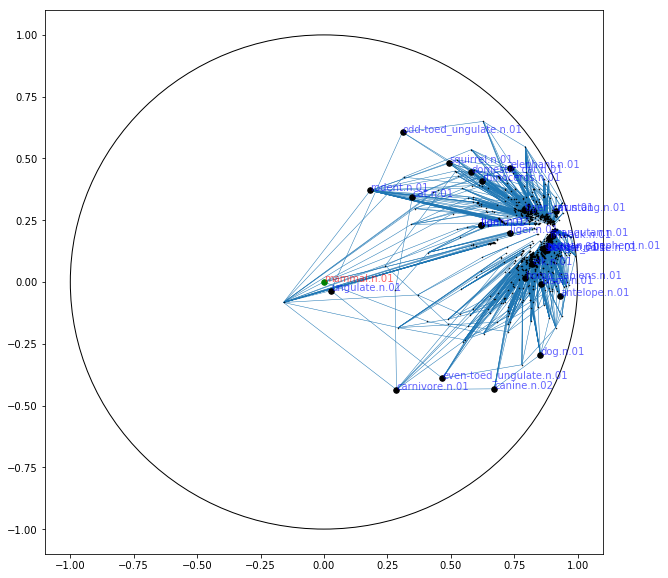

In [20]:
plot_embedings(model.get_layer('embeddings'))

In [21]:
plot_embedings(model.get_layer('embeddings'), mode='plotly', center=False)

## Check euclides distance

In [22]:
def get_euclides_model(latent_dim = 2):
    left_input = Input(shape=(1,))
    word_embd = Embedding(num_words, output_dim=latent_dim, name='embeddings')
    u_word = word_embd(left_input)
    u_word = Reshape(target_shape=[-1])(u_word)

    def u_w_distance(u):        
        w = word_embd.weights[0]

        ww = K.expand_dims(K.sum(K.square(w), 1), -1)
        uu = K.expand_dims(K.sum(K.square(u), -1), -1)    
        dist_uw_2 = - 2 * K.dot(u, K.transpose(w)) + uu + K.transpose(ww)
        return - dist_uw_2 # with sqrt model was performing badly... 

    x = Lambda(u_w_distance)(u_word)
    x = Activation('softmax')(x)
    model = Model(inputs=left_input, outputs=x)
    return model

model = get_euclides_model(latent_dim = 2)

Epoch 1/20
6575/6575 [==============================] - 1s - loss: 7.0629 - acc: 0.0000e+00     
Epoch 2/20
6575/6575 [==============================] - 1s - loss: 6.9871 - acc: 0.0000e+00     
Epoch 3/20
6575/6575 [==============================] - 1s - loss: 6.8043 - acc: 0.0000e+00     
Epoch 4/20
6575/6575 [==============================] - 1s - loss: 6.5022 - acc: 0.0000e+00     
Epoch 5/20
6575/6575 [==============================] - 1s - loss: 6.1082 - acc: 0.0000e+00     
Epoch 6/20
6575/6575 [==============================] - 1s - loss: 5.6849 - acc: 0.0000e+00     
Epoch 7/20
6575/6575 [==============================] - 1s - loss: 5.3091 - acc: 0.0000e+00     
Epoch 8/20
6575/6575 [==============================] - 1s - loss: 5.0219 - acc: 0.0000e+00     
Epoch 9/20
6575/6575 [==============================] - 1s - loss: 4.8212 - acc: 0.0000e+00     
Epoch 10/20
6575/6575 [==============================] - 1s - loss: 4.6836 - acc: 0.0000e+00     
Epoch 11/20
6575/6575 [======

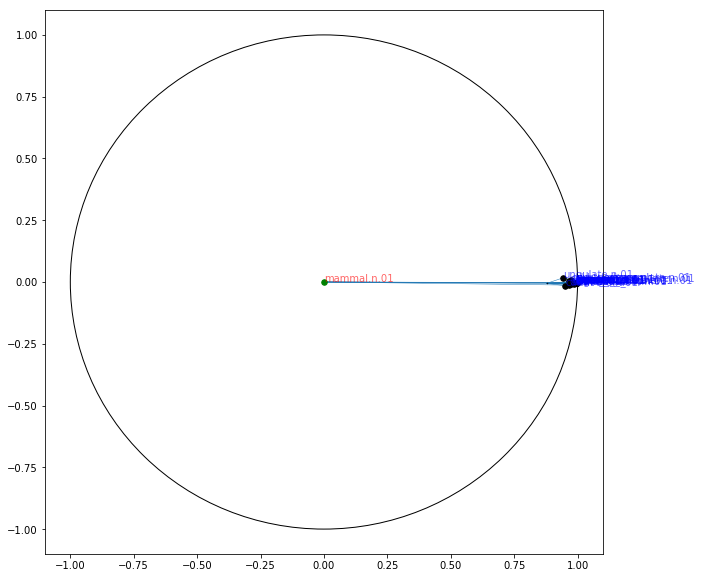

Epoch 1/30
6575/6575 [==============================] - 1s - loss: 4.1223 - acc: 0.0000e+00     
Epoch 2/30
6575/6575 [==============================] - 1s - loss: 4.0354 - acc: 0.0000e+00     
Epoch 3/30
6575/6575 [==============================] - 1s - loss: 3.9744 - acc: 0.0000e+00     
Epoch 4/30
6575/6575 [==============================] - 1s - loss: 3.9223 - acc: 0.0000e+00     
Epoch 5/30
6575/6575 [==============================] - 1s - loss: 3.8780 - acc: 0.0000e+00     
Epoch 6/30
6575/6575 [==============================] - 1s - loss: 3.8403 - acc: 0.0000e+00     
Epoch 7/30
6575/6575 [==============================] - 1s - loss: 3.8075 - acc: 0.0000e+00     
Epoch 8/30
6575/6575 [==============================] - 1s - loss: 3.7790 - acc: 0.0000e+00     
Epoch 9/30
6575/6575 [==============================] - 1s - loss: 3.7532 - acc: 0.0000e+00     
Epoch 10/30
6575/6575 [==============================] - 1s - loss: 3.7303 - acc: 0.0000e+00     
Epoch 11/30
6575/6575 [======

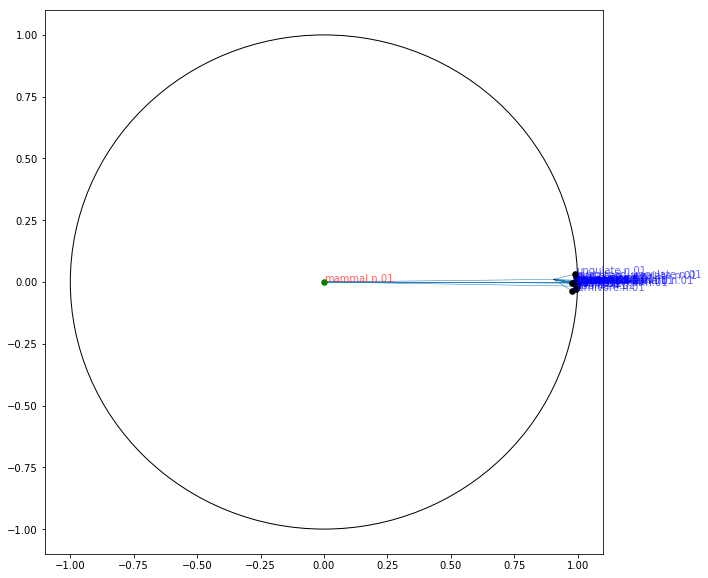

Epoch 1/15
6575/6575 [==============================] - 1s - loss: 3.5964 - acc: 0.0000e+00     
Epoch 2/15
6575/6575 [==============================] - 1s - loss: 3.5213 - acc: 0.0000e+00     
Epoch 3/15
6575/6575 [==============================] - 1s - loss: 3.4875 - acc: 0.0000e+00     
Epoch 4/15
6575/6575 [==============================] - 1s - loss: 3.4631 - acc: 0.0000e+00     
Epoch 5/15
6575/6575 [==============================] - 1s - loss: 3.4418 - acc: 0.0000e+00     
Epoch 6/15
6575/6575 [==============================] - 1s - loss: 3.4245 - acc: 0.0000e+00     
Epoch 7/15
6575/6575 [==============================] - 1s - loss: 3.4104 - acc: 0.0000e+00     
Epoch 8/15
6575/6575 [==============================] - 1s - loss: 3.3981 - acc: 0.0000e+00     
Epoch 9/15
6575/6575 [==============================] - 1s - loss: 3.3866 - acc: 0.0000e+00     
Epoch 10/15
6575/6575 [==============================] - 1s - loss: 3.3779 - acc: 0.0000e+00     
Epoch 11/15
6575/6575 [======

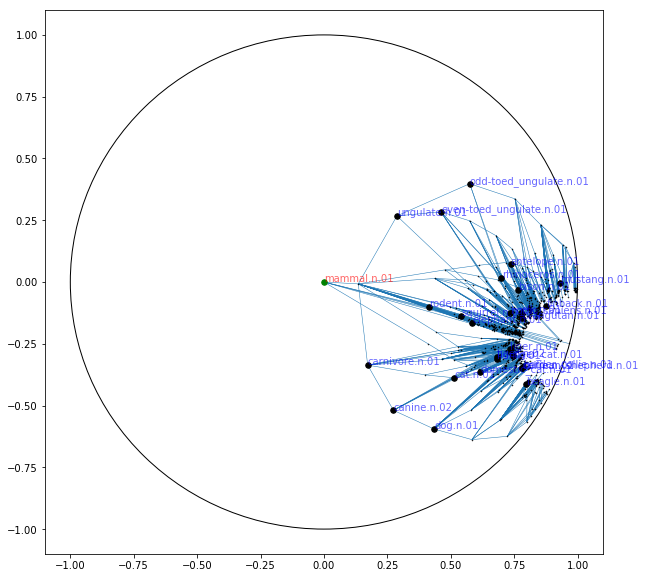

Epoch 1/15
6575/6575 [==============================] - 1s - loss: 3.3334 - acc: 0.0000e+00     
Epoch 2/15
6575/6575 [==============================] - 1s - loss: 3.3222 - acc: 0.0000e+00     
Epoch 3/15
6575/6575 [==============================] - 1s - loss: 3.3205 - acc: 0.0000e+00     
Epoch 4/15
6575/6575 [==============================] - 1s - loss: 3.3191 - acc: 0.0000e+00     
Epoch 5/15
6575/6575 [==============================] - 1s - loss: 3.3176 - acc: 0.0000e+00     
Epoch 6/15
6575/6575 [==============================] - 1s - loss: 3.3163 - acc: 0.0000e+00     
Epoch 7/15
6575/6575 [==============================] - 1s - loss: 3.3150 - acc: 0.0000e+00     
Epoch 8/15
6575/6575 [==============================] - 1s - loss: 3.3137 - acc: 0.0000e+00     
Epoch 9/15
6575/6575 [==============================] - 1s - loss: 3.3124 - acc: 0.0000e+00     
Epoch 10/15
6575/6575 [==============================] - 1s - loss: 3.3112 - acc: 0.0000e+00     
Epoch 11/15
6575/6575 [======

In [23]:
model.compile(optimizer=Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=30)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=15)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=15)
plot_embedings(model.get_layer('embeddings'))

In [24]:
model.save_weights("models/connections_euclides.h5")

In [25]:
model = get_euclides_model(latent_dim=2)
model.load_weights("models/connections_euclides.h5")

In [27]:
plot_embedings(model.get_layer('embeddings'), mode='plotly', center=False)

## Check euclides distance with sampling

### Define model with sampling

In [28]:
def get_euclides_with_sampling(latent_dim = 2):

    left_input = Input(shape=(1,))
    right_input = Input(shape=(1,))
    left_samples = Input(shape=(num_samples,))

    word_embd = Embedding(num_words, output_dim=latent_dim, name='embeddings')

    u_word = word_embd(left_input)
    v_word = word_embd(right_input)
    u_samples = word_embd(left_samples)

    def u_w_distance(x):
        u, u_s = x
        ww = K.expand_dims(K.sum(K.square(u_s), -1), -1)
        uu = K.expand_dims(K.sum(K.square(u), -1), -1)     
        dot = K.sum(u * u_s, -1, keepdims=True)    
        dist_uw_2 = uu + ww - 2 * dot
        return dist_uw_2 


    us_distance = Reshape([-1])(Lambda(u_w_distance)([u_word, u_samples]))
    uv_distance = Reshape([-1])(Lambda(u_w_distance)([u_word, v_word]))


    def sampled_loss(x):
        uv_distance, us_distance = x
        uv_distance = K.exp( - uv_distance)
        us_distance = K.sum( K.exp( - us_distance), -1, keepdims=True)
        loss = - K.log(uv_distance/(us_distance + K.epsilon()) + K.epsilon())
        return loss

    x = Lambda(sampled_loss)([uv_distance, us_distance])

    model = Model([left_input, right_input, left_samples], x)
    word_embd.set_weights([word_embd.get_weights()[0]*0.1])
    return model

model = get_euclides_with_sampling(latent_dim = 2)

### Train model with sampling (naive gradients)

Epoch 1/20
500/500 [==============================] - 4s - loss: 2.8055 - acc: 1.2500e-04     
Epoch 2/20
500/500 [==============================] - 3s - loss: 2.4101 - acc: 6.2500e-05     
Epoch 3/20
500/500 [==============================] - 3s - loss: 2.2629 - acc: 0.0000e+00     
Epoch 4/20
500/500 [==============================] - 3s - loss: 2.2035 - acc: 0.0000e+00     
Epoch 5/20
500/500 [==============================] - 3s - loss: 2.1650 - acc: 0.0000e+00     
Epoch 6/20
500/500 [==============================] - 3s - loss: 2.1371 - acc: 0.0000e+00     
Epoch 7/20
500/500 [==============================] - 3s - loss: 2.0984 - acc: 0.0000e+00     
Epoch 8/20
500/500 [==============================] - 4s - loss: 2.0964 - acc: 0.0000e+00     
Epoch 9/20
500/500 [==============================] - 3s - loss: 2.0686 - acc: 6.2500e-05     
Epoch 10/20
500/500 [==============================] - 3s - loss: 2.0643 - acc: 6.2500e-05     
Epoch 11/20
500/500 [============================

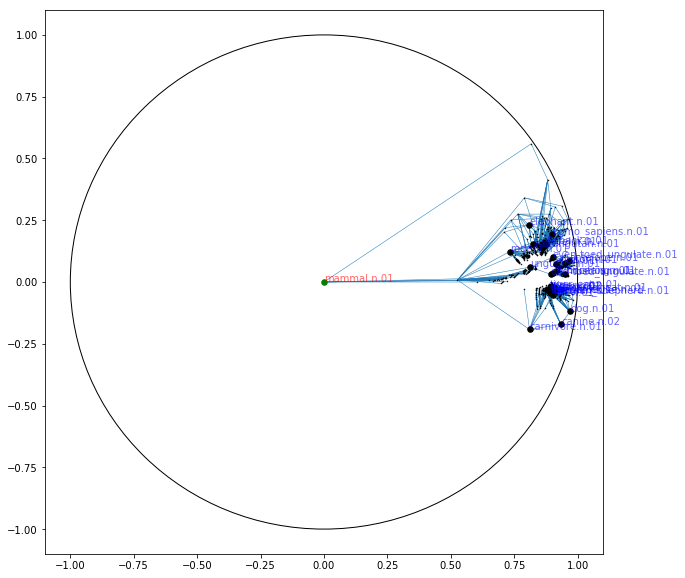

Epoch 1/30
500/500 [==============================] - 4s - loss: 1.9205 - acc: 3.7500e-04     
Epoch 2/30
500/500 [==============================] - 3s - loss: 1.8692 - acc: 4.3750e-04     
Epoch 3/30
500/500 [==============================] - 3s - loss: 1.8336 - acc: 3.1250e-04     
Epoch 4/30
500/500 [==============================] - 3s - loss: 1.7995 - acc: 1.8750e-04     
Epoch 5/30
500/500 [==============================] - 4s - loss: 1.7799 - acc: 1.8750e-04     
Epoch 6/30
500/500 [==============================] - 4s - loss: 1.7624 - acc: 3.7500e-04     
Epoch 7/30
500/500 [==============================] - 4s - loss: 1.7423 - acc: 3.1250e-04     
Epoch 8/30
500/500 [==============================] - 4s - loss: 1.7472 - acc: 1.8750e-04     
Epoch 9/30
500/500 [==============================] - 4s - loss: 1.7340 - acc: 6.2500e-05     
Epoch 10/30
500/500 [==============================] - 3s - loss: 1.7233 - acc: 1.2500e-04     
Epoch 11/30
500/500 [============================

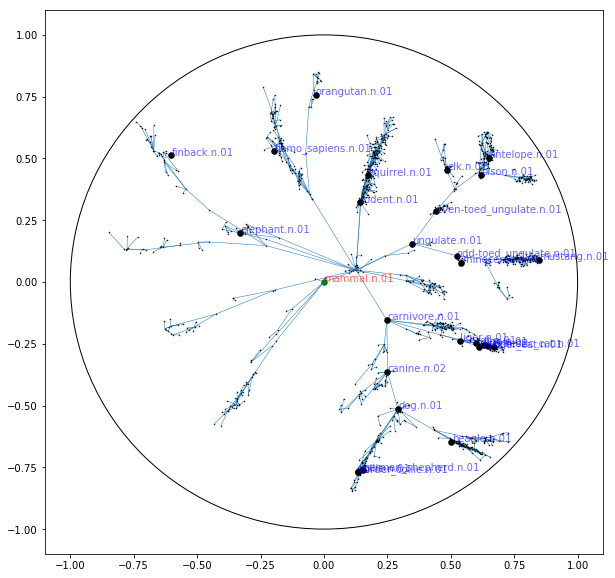

Epoch 1/10
500/500 [==============================] - 4s - loss: 1.6892 - acc: 0.0000e+00     
Epoch 2/10
500/500 [==============================] - 3s - loss: 1.6756 - acc: 1.8750e-04     
Epoch 3/10
500/500 [==============================] - 3s - loss: 1.6792 - acc: 6.2500e-05     
Epoch 4/10
500/500 [==============================] - 4s - loss: 1.7034 - acc: 6.2500e-05     
Epoch 5/10
500/500 [==============================] - 4s - loss: 1.7029 - acc: 6.2500e-05     
Epoch 6/10
500/500 [==============================] - 4s - loss: 1.6888 - acc: 1.2500e-04     
Epoch 7/10
500/500 [==============================] - 4s - loss: 1.6893 - acc: 6.2500e-05     
Epoch 8/10
500/500 [==============================] - 3s - loss: 1.6883 - acc: 6.2500e-05     
Epoch 9/10
500/500 [==============================] - 4s - loss: 1.6932 - acc: 6.2500e-05     
Epoch 10/10
500/500 [==============================] - 4s - loss: 1.6867 - acc: 1.2500e-04     
28  targets found


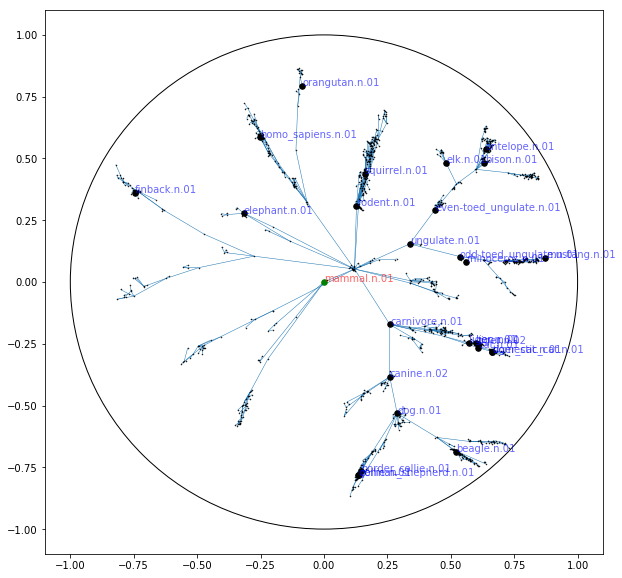

Epoch 1/10
500/500 [==============================] - 4s - loss: 1.6684 - acc: 1.8750e-04     
Epoch 2/10
500/500 [==============================] - 3s - loss: 1.6799 - acc: 6.2500e-05     
Epoch 3/10
500/500 [==============================] - 3s - loss: 1.6880 - acc: 6.2500e-05     
Epoch 4/10
500/500 [==============================] - 3s - loss: 1.6919 - acc: 2.5000e-04     
Epoch 5/10
500/500 [==============================] - 3s - loss: 1.6891 - acc: 6.2500e-05     
Epoch 6/10
500/500 [==============================] - 3s - loss: 1.6989 - acc: 3.7500e-04     
Epoch 7/10
500/500 [==============================] - 4s - loss: 1.6847 - acc: 1.2500e-04     
Epoch 8/10
500/500 [==============================] - 4s - loss: 1.6663 - acc: 6.2500e-05     
Epoch 9/10
500/500 [==============================] - 4s - loss: 1.6945 - acc: 1.2500e-04     
Epoch 10/10
500/500 [==============================] - 3s - loss: 1.6760 - acc: 0.0000e+00     
28  targets found


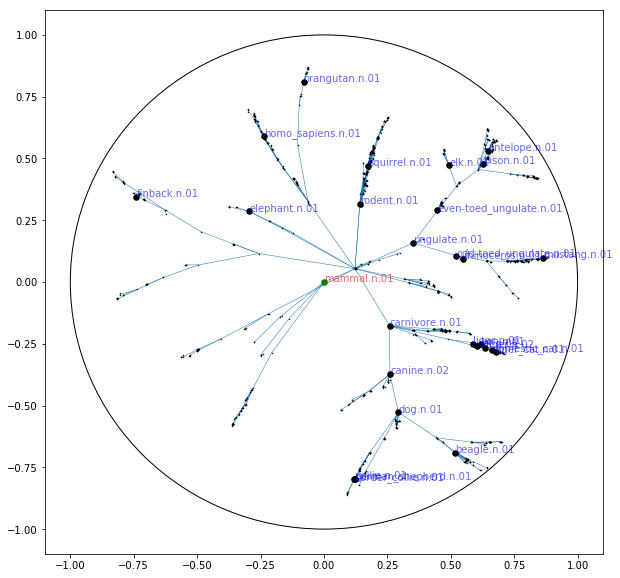

In [29]:
model.compile(optimizer=Adam(0.001), loss=custom_loss, metrics=['accuracy'])
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.01), loss=custom_loss, metrics=['accuracy'])
model.fit_generator(train_gen, steps_per_epoch=500, epochs=30)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.005), loss=custom_loss, metrics=['accuracy'])
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.001), loss=custom_loss, metrics=['accuracy'])
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

In [30]:
model.save_weights("models/connections_euclides_sampled.h5")

In [31]:
model = get_euclides_with_sampling(latent_dim = 2)
model.load_weights("models/connections_euclides_sampled.h5")

In [33]:
plot_embedings(model.get_layer('embeddings'), mode='plotly', center=False)

## Check Poincare (naive version without metric)

In [35]:
def get_poincare_model(latent_dim = 2):

    left_input = Input(shape=(1,))
    right_input = Input(shape=(1,))
    left_samples = Input(shape=(num_samples,))

    word_embd = Embedding(num_words, output_dim=latent_dim, name='embeddings')

    u_word = word_embd(left_input)
    v_word = word_embd(right_input)
    u_samples = word_embd(left_samples)

    def u_w_distance(x):
        u, v_s = x
        ww = K.expand_dims(K.sum(K.square(v_s), -1), -1)
        uu = K.expand_dims(K.sum(K.square(u), -1), -1) 

        dot = K.sum(u * v_s, -1, keepdims=True)    
        dist_uw_2 = uu + ww - 2 * dot
        return dist_uw_2


    uv_distance = Reshape([-1])(Lambda(u_w_distance)([u_word, v_word]))
    us_distance = Reshape([-1])(Lambda(u_w_distance)([u_word, u_samples]))


    def arcosh(x):    
        return K.log(x + K.sqrt( K.square(x) - 1 ))


    def to_poincare_disk(x):
        u, v, uv_dist = x     

        uu = K.sum(K.square(u), -1)
        vv = K.sum(K.square(v), -1)

        alpha = K.clip((1 - uu), K.epsilon(), 1 - K.epsilon())
        beta = K.clip((1 - vv), K.epsilon(), 1 - K.epsilon())

        gamma = 1 + 2 * uv_dist / (alpha * beta)
        gamma = K.maximum(gamma, 1.0 + K.epsilon())    
        return arcosh(gamma)

    uv_distance = Lambda(to_poincare_disk)([u_word, v_word, uv_distance])
    us_distance = Lambda(to_poincare_disk)([u_word, u_samples, us_distance])


    def sampled_loss(x):
        uv_distance, us_distance = x
        uv_distance = K.exp( - uv_distance)
        us_distance = K.sum( K.exp( - us_distance), -1, keepdims=True)
        loss = - K.log(uv_distance/(us_distance + K.epsilon()) + K.epsilon())
        return loss

    x = Lambda(sampled_loss)([uv_distance, us_distance])

    def custom_loss(y_true, y_pred):
        return K.mean(y_pred)

    model = Model([left_input, right_input, left_samples], x)
    word_embd.set_weights([word_embd.get_weights()[0]*0.1])
    return model
    
model = get_poincare_model(latent_dim = 2)

Epoch 1/20
500/500 [==============================] - 4s - loss: 2.8835     
Epoch 2/20
500/500 [==============================] - 4s - loss: 2.7118     
Epoch 3/20
500/500 [==============================] - 4s - loss: 2.6155     
Epoch 4/20
500/500 [==============================] - 4s - loss: 2.5516     
Epoch 5/20
500/500 [==============================] - 4s - loss: 2.5067     
Epoch 6/20
500/500 [==============================] - 3s - loss: 2.4703     
Epoch 7/20
500/500 [==============================] - 3s - loss: 2.4429     
Epoch 8/20
500/500 [==============================] - 3s - loss: 2.4295     
Epoch 9/20
500/500 [==============================] - 3s - loss: 2.3915     
Epoch 10/20
500/500 [==============================] - 3s - loss: 2.3843     
Epoch 11/20
500/500 [==============================] - 4s - loss: 2.3655     
Epoch 12/20
500/500 [==============================] - 4s - loss: 2.3669     
Epoch 13/20
500/500 [==============================] - 3s - loss: 2.3234 

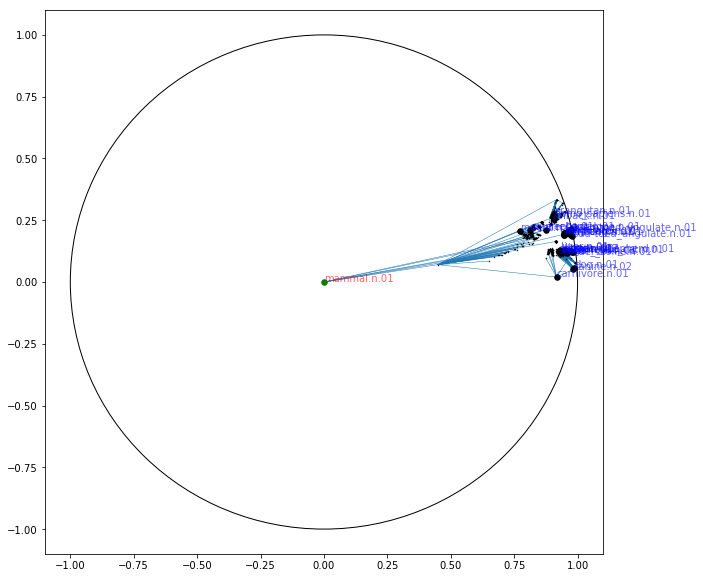

Epoch 1/30
500/500 [==============================] - 4s - loss: 2.2410     
Epoch 2/30
500/500 [==============================] - 3s - loss: 2.2030     
Epoch 3/30
500/500 [==============================] - 3s - loss: 2.1659     
Epoch 4/30
500/500 [==============================] - 3s - loss: 2.1308     
Epoch 5/30
500/500 [==============================] - 3s - loss: 2.0927     
Epoch 6/30
500/500 [==============================] - 3s - loss: 2.0732     
Epoch 7/30
500/500 [==============================] - 3s - loss: 2.0438     
Epoch 8/30
500/500 [==============================] - 3s - loss: 2.0206     
Epoch 9/30
500/500 [==============================] - 4s - loss: 2.0004     
Epoch 10/30
500/500 [==============================] - 3s - loss: 1.9968     
Epoch 11/30
500/500 [==============================] - 3s - loss: 1.9794     
Epoch 12/30
500/500 [==============================] - 4s - loss: 1.9787     
Epoch 13/30
500/500 [==============================] - 4s - loss: 1.9714 

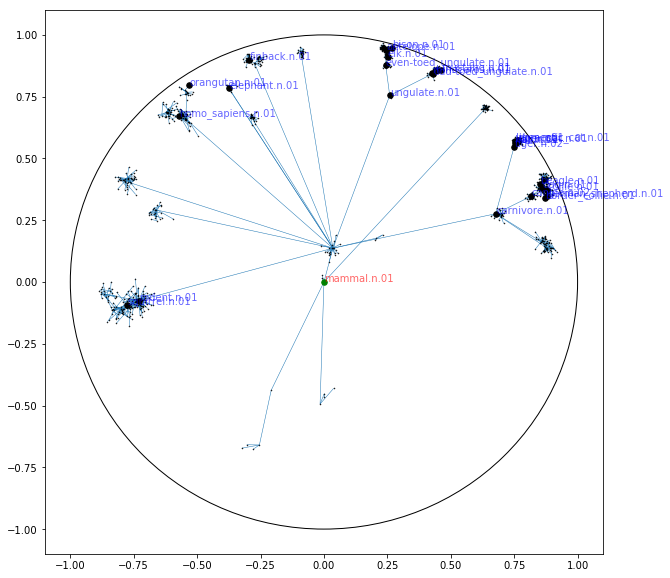

Epoch 1/10
500/500 [==============================] - 5s - loss: 1.9200     
Epoch 2/10
500/500 [==============================] - 4s - loss: 1.9102     
Epoch 3/10
500/500 [==============================] - 4s - loss: 1.9089     
Epoch 4/10
500/500 [==============================] - 4s - loss: 1.9142     
Epoch 5/10
500/500 [==============================] - 3s - loss: 1.9051     
Epoch 6/10
500/500 [==============================] - 4s - loss: 1.9146     
Epoch 7/10
500/500 [==============================] - 3s - loss: 1.9155     
Epoch 8/10
500/500 [==============================] - 4s - loss: 1.8980     
Epoch 9/10
500/500 [==============================] - 4s - loss: 1.8959     
Epoch 10/10
500/500 [==============================] - 4s - loss: 1.9207     
28  targets found


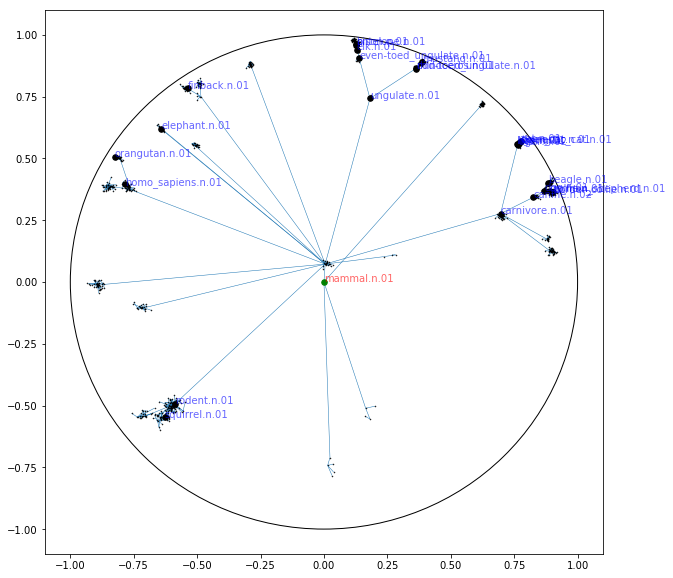

Epoch 1/10
500/500 [==============================] - 5s - loss: 1.8979     
Epoch 2/10
500/500 [==============================] - 4s - loss: 1.9031     
Epoch 3/10
500/500 [==============================] - 4s - loss: 1.8917     
Epoch 4/10
500/500 [==============================] - 4s - loss: 1.9031     
Epoch 5/10
500/500 [==============================] - 3s - loss: 1.8879     
Epoch 6/10
500/500 [==============================] - 3s - loss: 1.8873     
Epoch 7/10
500/500 [==============================] - 4s - loss: 1.8891     
Epoch 8/10
500/500 [==============================] - 3s - loss: 1.8993     
Epoch 9/10
500/500 [==============================] - 4s - loss: 1.8864     
Epoch 10/10
500/500 [==============================] - 3s - loss: 1.8968     
28  targets found


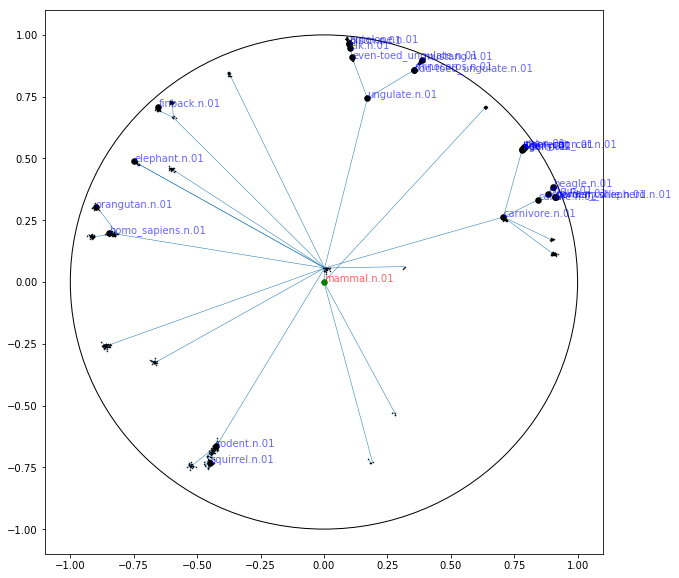

In [36]:
model.compile(optimizer=Adam(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.002), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=30)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.001), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=Adam(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

In [37]:
model.save_weights("models/connections_poincare_naive_adam.h5")

In [38]:
model = get_poincare_model(latent_dim = 2)
model.load_weights("models/connections_poincare_naive_adam.h5")

In [39]:
plot_embedings(model.get_layer('embeddings'), mode='plotly')

## Check Poincare with proper gradients

In [43]:
model = get_poincare_model(latent_dim = 2)

### SGD version

In [44]:
from optimizers import SGDPoincare

Epoch 1/25
500/500 [==============================] - 5s - loss: 2.9525     
Epoch 2/25
500/500 [==============================] - 3s - loss: 2.8837     
Epoch 3/25
500/500 [==============================] - 4s - loss: 2.8392     
Epoch 4/25
500/500 [==============================] - 3s - loss: 2.7987     
Epoch 5/25
500/500 [==============================] - 3s - loss: 2.7731     
Epoch 6/25
500/500 [==============================] - 3s - loss: 2.7495     
Epoch 7/25
500/500 [==============================] - 3s - loss: 2.7291     
Epoch 8/25
500/500 [==============================] - 3s - loss: 2.7106     
Epoch 9/25
500/500 [==============================] - 3s - loss: 2.6988     
Epoch 10/25
500/500 [==============================] - 3s - loss: 2.6865     
Epoch 11/25
500/500 [==============================] - 3s - loss: 2.6664     
Epoch 12/25
500/500 [==============================] - 3s - loss: 2.6572     
Epoch 13/25
500/500 [==============================] - 3s - loss: 2.6509 

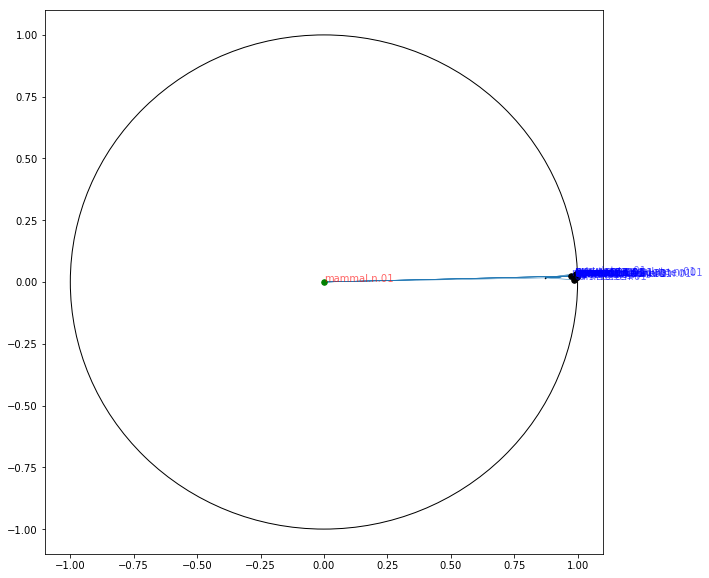

Epoch 1/20
500/500 [==============================] - 5s - loss: 2.5712     
Epoch 2/20
500/500 [==============================] - 4s - loss: 2.5635     
Epoch 3/20
500/500 [==============================] - 4s - loss: 2.5526     
Epoch 4/20
500/500 [==============================] - 4s - loss: 2.5580     
Epoch 5/20
500/500 [==============================] - 4s - loss: 2.5515     
Epoch 6/20
500/500 [==============================] - 3s - loss: 2.5471     
Epoch 7/20
500/500 [==============================] - 4s - loss: 2.5386     
Epoch 8/20
500/500 [==============================] - 4s - loss: 2.5334     
Epoch 9/20
500/500 [==============================] - 4s - loss: 2.5430     
Epoch 10/20
500/500 [==============================] - 4s - loss: 2.5250     
Epoch 11/20
500/500 [==============================] - 4s - loss: 2.5253     
Epoch 12/20
500/500 [==============================] - 4s - loss: 2.5117     
Epoch 13/20
500/500 [==============================] - 4s - loss: 2.5217 

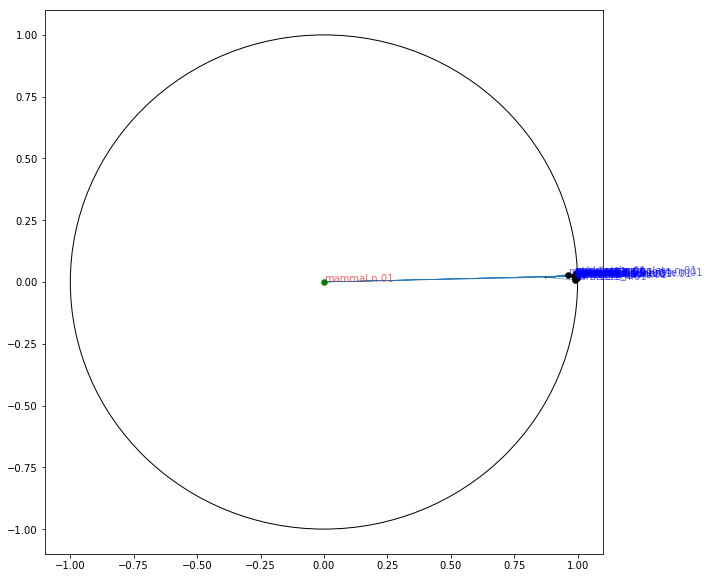

Epoch 1/20
500/500 [==============================] - 4s - loss: 2.5027     
Epoch 2/20
500/500 [==============================] - 3s - loss: 2.4895     
Epoch 3/20
500/500 [==============================] - 3s - loss: 2.4782     
Epoch 4/20
500/500 [==============================] - 3s - loss: 2.4752     
Epoch 5/20
500/500 [==============================] - 3s - loss: 2.4841     
Epoch 6/20
500/500 [==============================] - 3s - loss: 2.4859     
Epoch 7/20
500/500 [==============================] - 3s - loss: 2.4790     
Epoch 8/20
500/500 [==============================] - 4s - loss: 2.4725     
Epoch 9/20
500/500 [==============================] - 3s - loss: 2.4604     
Epoch 10/20
500/500 [==============================] - 3s - loss: 2.4575     
Epoch 11/20
500/500 [==============================] - 3s - loss: 2.4627     
Epoch 12/20
500/500 [==============================] - 3s - loss: 2.4609     
Epoch 13/20
500/500 [==============================] - 4s - loss: 2.4462 

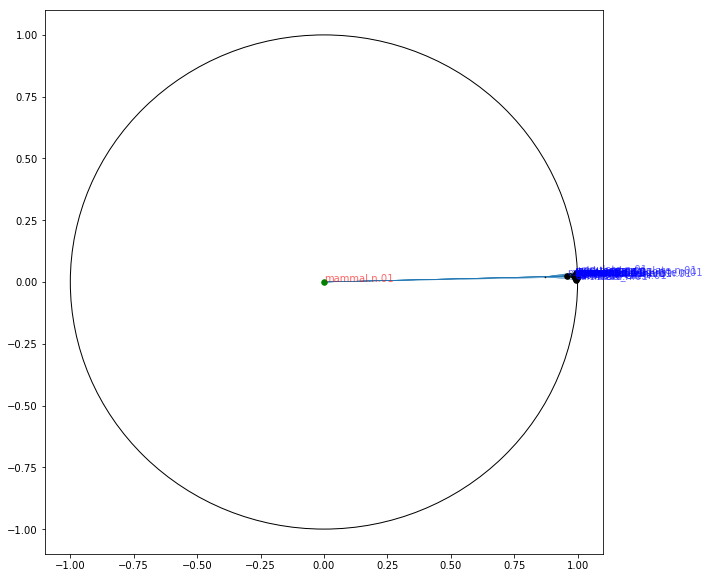

Epoch 1/10
500/500 [==============================] - 4s - loss: 2.4441     
Epoch 2/10
500/500 [==============================] - 3s - loss: 2.4401     
Epoch 3/10
500/500 [==============================] - 3s - loss: 2.4474     
Epoch 4/10
500/500 [==============================] - 4s - loss: 2.4294     
Epoch 5/10
500/500 [==============================] - 4s - loss: 2.4413     
Epoch 6/10
500/500 [==============================] - 3s - loss: 2.4376     
Epoch 7/10
500/500 [==============================] - 4s - loss: 2.4505     
Epoch 8/10
500/500 [==============================] - 4s - loss: 2.4375     
Epoch 9/10
500/500 [==============================] - 3s - loss: 2.4298     
Epoch 10/10
500/500 [==============================] - 4s - loss: 2.4373     
28  targets found


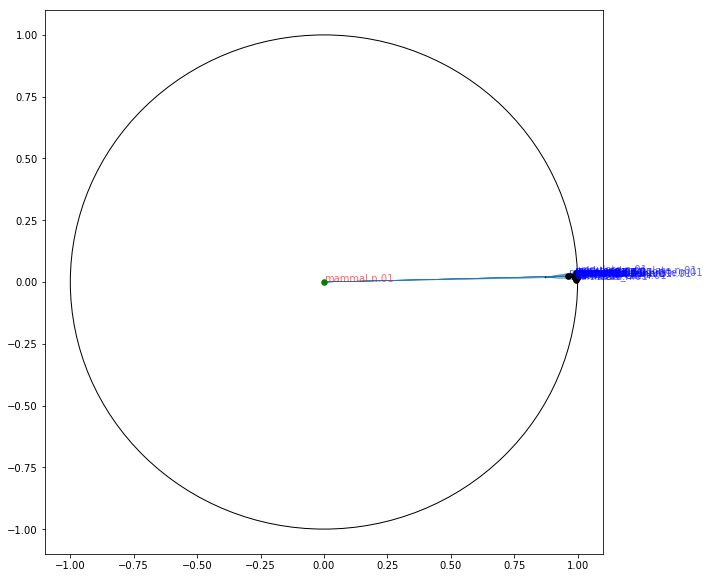

In [45]:
model.compile(optimizer=SGDPoincare(lr=0.0005, momentum=0.9), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=25)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=SGDPoincare(lr=0.001, momentum=0.9), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=SGDPoincare(lr=0.002, momentum=0.9), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=SGDPoincare(lr=0.0005, momentum=0.9), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

In [46]:
model.save_weights("models/connections_poincare_sgd.h5")

In [47]:
model = get_poincare_model(latent_dim = 2)
model.load_weights("models/connections_poincare_sgd.h5")

In [48]:
plot_embedings(model.get_layer('embeddings'), mode='plotly', center=False)

### Adam version

In [49]:
model = get_poincare_model(latent_dim = 2)

In [50]:
from optimizers import AdamPoincare

Epoch 1/20
500/500 [==============================] - 5s - loss: 2.8883     
Epoch 2/20
500/500 [==============================] - 4s - loss: 2.7262     
Epoch 3/20
500/500 [==============================] - 4s - loss: 2.6254     
Epoch 4/20
500/500 [==============================] - 4s - loss: 2.5633     
Epoch 5/20
500/500 [==============================] - 4s - loss: 2.5269     
Epoch 6/20
500/500 [==============================] - 4s - loss: 2.4917     
Epoch 7/20
500/500 [==============================] - 3s - loss: 2.4710     
Epoch 8/20
500/500 [==============================] - 3s - loss: 2.4453     
Epoch 9/20
500/500 [==============================] - 3s - loss: 2.4266     
Epoch 10/20
500/500 [==============================] - 4s - loss: 2.4049     
Epoch 11/20
500/500 [==============================] - 4s - loss: 2.3753     
Epoch 12/20
500/500 [==============================] - 4s - loss: 2.3723     
Epoch 13/20
500/500 [==============================] - 3s - loss: 2.3576 

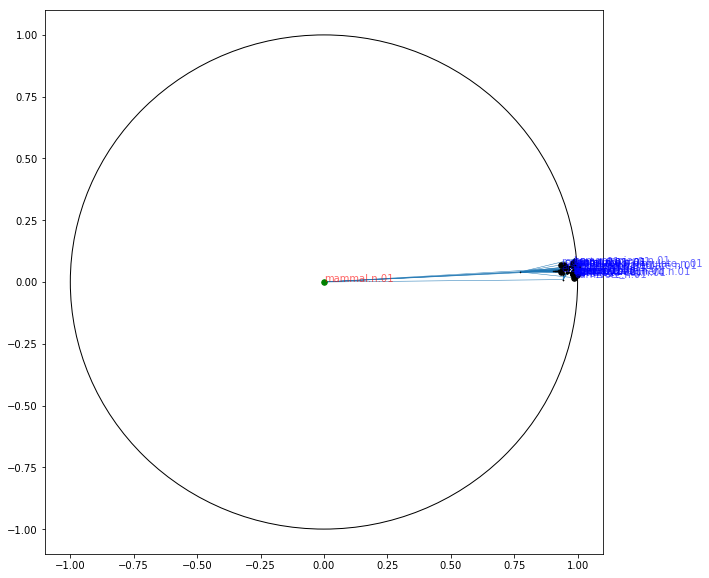

Epoch 1/30
500/500 [==============================] - 5s - loss: 2.2703     
Epoch 2/30
500/500 [==============================] - 4s - loss: 2.2554     
Epoch 3/30
500/500 [==============================] - 4s - loss: 2.2336     
Epoch 4/30
500/500 [==============================] - 4s - loss: 2.2118     
Epoch 5/30
500/500 [==============================] - 3s - loss: 2.1928     
Epoch 6/30
500/500 [==============================] - 4s - loss: 2.1715     
Epoch 7/30
500/500 [==============================] - 3s - loss: 2.1646     
Epoch 8/30
500/500 [==============================] - 3s - loss: 2.1466     
Epoch 9/30
500/500 [==============================] - 4s - loss: 2.1242     
Epoch 10/30
500/500 [==============================] - 4s - loss: 2.0911     
Epoch 11/30
500/500 [==============================] - 4s - loss: 2.0713     
Epoch 12/30
500/500 [==============================] - 4s - loss: 2.0578     
Epoch 13/30
500/500 [==============================] - 4s - loss: 2.0431 

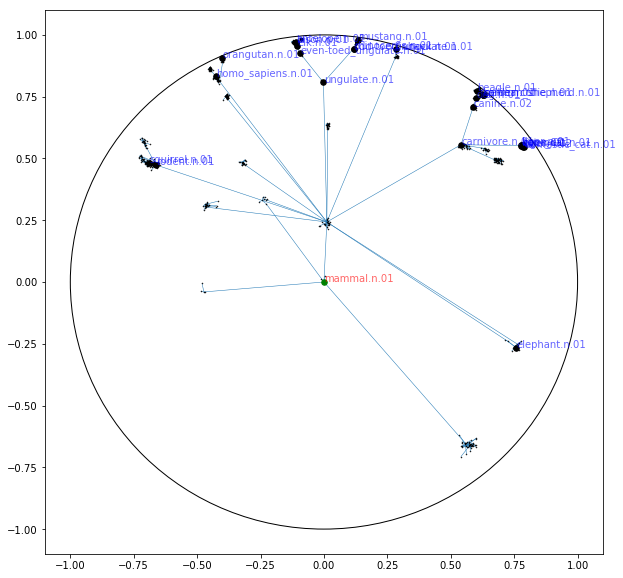

Epoch 1/10
500/500 [==============================] - 5s - loss: 1.9711     
Epoch 2/10
500/500 [==============================] - 3s - loss: 2.0080     
Epoch 3/10
500/500 [==============================] - 4s - loss: 2.0230     
Epoch 4/10
500/500 [==============================] - 4s - loss: 2.0249     
Epoch 5/10
500/500 [==============================] - 4s - loss: 2.0463     
Epoch 6/10
500/500 [==============================] - 4s - loss: 2.1038     
Epoch 7/10
500/500 [==============================] - 4s - loss: 2.1489     
Epoch 8/10
500/500 [==============================] - 4s - loss: 2.1206     
Epoch 9/10
500/500 [==============================] - 4s - loss: 2.1371     
Epoch 10/10
500/500 [==============================] - 4s - loss: 2.2217     
28  targets found


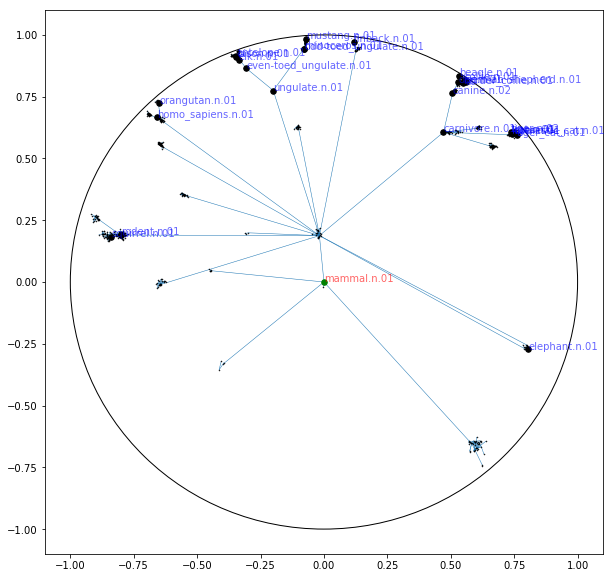

Epoch 1/10
500/500 [==============================] - 5s - loss: 2.2286     
Epoch 2/10
500/500 [==============================] - 4s - loss: 2.2080     
Epoch 3/10
500/500 [==============================] - 3s - loss: 2.2226     
Epoch 4/10
500/500 [==============================] - 4s - loss: 2.2343     
Epoch 5/10
500/500 [==============================] - 4s - loss: 2.2406     
Epoch 6/10
500/500 [==============================] - 4s - loss: 2.2767     
Epoch 7/10
500/500 [==============================] - 3s - loss: 2.2452     
Epoch 8/10
500/500 [==============================] - 4s - loss: 2.3050     
Epoch 9/10
500/500 [==============================] - 4s - loss: 2.2752     
Epoch 10/10
500/500 [==============================] - 3s - loss: 2.3222     
28  targets found


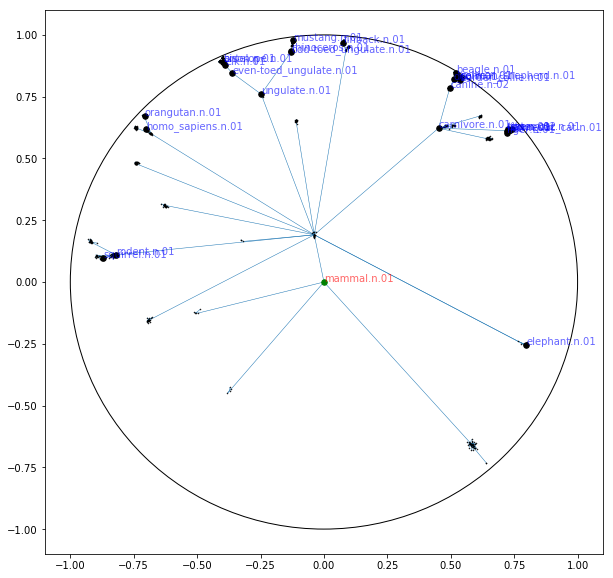

In [51]:
model.compile(optimizer=AdamPoincare(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=AdamPoincare(0.001), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=30)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=AdamPoincare(0.0008), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

model.compile(optimizer=AdamPoincare(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)
plot_embedings(model.get_layer('embeddings'))

In [52]:
model.save_weights("models/connections_poincare_adam.h5")

In [53]:
model = get_poincare_model(latent_dim = 2)
model.load_weights("models/connections_poincare_adam.h5")

In [57]:
plot_embedings(model.get_layer('embeddings'), mode='plotly', center=False)

## Check 3D embedings for Poincare with Adam

In [58]:
from utils import plotly_embedings3d

def plot_embedings3d(word_embd_layer):    
    w_embd = word_embd_layer.get_weights()[0]
    words = list(map(lambda x: index2word[x], range(num_words)))
    embeddings_df = pd.DataFrame( w_embd, columns=['x1', 'x2', 'x3'], index=words)        
    plotly_embedings3d(embeddings_df, edges_df)

In [59]:
from optimizers import AdamPoincare
model = get_poincare_model(latent_dim = 3)

In [60]:
model.compile(optimizer=AdamPoincare(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20)

model.compile(optimizer=AdamPoincare(0.001), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=30)

model.compile(optimizer=AdamPoincare(0.0008), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)

model.compile(optimizer=AdamPoincare(0.0005), loss=custom_loss)
model.fit_generator(train_gen, steps_per_epoch=500, epochs=10)

Epoch 1/20
500/500 [==============================] - 5s - loss: 2.8740     
Epoch 2/20
500/500 [==============================] - 3s - loss: 2.6924     
Epoch 3/20
500/500 [==============================] - 4s - loss: 2.5821     
Epoch 4/20
500/500 [==============================] - 4s - loss: 2.5151     
Epoch 5/20
500/500 [==============================] - 4s - loss: 2.4579     
Epoch 6/20
500/500 [==============================] - 4s - loss: 2.4303     
Epoch 7/20
500/500 [==============================] - 3s - loss: 2.3994     
Epoch 8/20
500/500 [==============================] - 4s - loss: 2.3801     
Epoch 9/20
500/500 [==============================] - 4s - loss: 2.3578     
Epoch 10/20
500/500 [==============================] - 4s - loss: 2.3415     
Epoch 11/20
500/500 [==============================] - 4s - loss: 2.3276     
Epoch 12/20
500/500 [==============================] - 4s - loss: 2.3029     
Epoch 13/20
500/500 [==============================] - 4s - loss: 2.2939 

In [61]:
model.save_weights("models/connections_poincare_adam_3d.h5")

In [62]:
model = get_poincare_model(latent_dim = 3)
model.load_weights("models/connections_poincare_adam_3d.h5")

In [63]:
plot_embedings3d(model.get_layer('embeddings'))